# COMP 215 - Project 01

#### Name: Ben Blair
#### Date: 27/02/2023

This application allows the user to plot the close-approach record for the near earth objects in a given date range.

Note: All data is pulled from NASA's Near Earth Object Web Service (NeoWs).

## Import

In [144]:
# Import the necessary modules
import datetime, json, requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pprint import pprint

# Set the API key
API_KEY = 'GT5a6VBQVVTnT8H1jSPfja2DfDMaC1d0UsYeWsYW'

## Set the Parameters

> `start_date`: Start date for the search period. Must be specified in 'YYYY-MM-DD' format.

> `end_date`: End date for the search period. Must be specified in 'YYYY-MM-DD' format.

> `orbiting_body`: The celestial body around which the neo orbits.

> `only_hazardous`: If set to `True`, only neos identified as potentially hazardous will be displayed. If set to `False`, all neos will be displayed.

In [200]:
# Define the parameters
start_date = '2023-02-14'
end_date = '2023-02-21'
orbiting_body = 'Earth'
only_hazardous = True

## Query the NASA Database

In [201]:
url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&end_date={end_date}&api_key={API_KEY}'
response = requests.request("GET", url, headers={}, data={})
data = json.loads(response.text)

In [202]:
neo_count = data['element_count']
neos = [neo for day in data['near_earth_objects'] for neo in data['near_earth_objects'][day]]

print(f'{neo_count} near earth objects detected for the period {start_date} to {end_date}.')

pprint(neos)  # TODO: Delete this line when finished

125 near earth objects detected for the period 2023-02-14 to 2023-02-21.
[{'absolute_magnitude_h': 19.52,
  'close_approach_data': [{'close_approach_date': '2023-02-20',
                           'close_approach_date_full': '2023-Feb-20 15:19',
                           'epoch_date_close_approach': 1676906340000,
                           'miss_distance': {'astronomical': '0.4986302928',
                                             'kilometers': '74594029.720356336',
                                             'lunar': '193.9671838992',
                                             'miles': '46350580.7632399968'},
                           'orbiting_body': 'Earth',
                           'relative_velocity': {'kilometers_per_hour': '80353.902629578',
                                                 'kilometers_per_second': '22.3205285082',
                                                 'miles_per_hour': '49928.7902200286'}}],
  'estimated_diameter': {'feet': {'estimated_diame

## Get Only Hazardous NEOs

In [203]:
if only_hazardous == True:
    neo_ids = [neo['id'] for neo in neos if neo['is_potentially_hazardous_asteroid'] == True]
else:
    neo_ids = [neo['id'] for neo in neos]

pprint(neo_ids)  # TODO: Delete this line when finished

['54340780',
 '2037638',
 '3448993',
 '54100193',
 '2199145',
 '2419880',
 '3840136',
 '54316644',
 '3843589',
 '3989671']


## Fetch Orbital Data for Each NEO

In [204]:
def get_neo_data(id):
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}/?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    
    approach_dates = [datetime.date.fromisoformat(approach['close_approach_date']) for approach in data['close_approach_data'] if approach['orbiting_body'] == orbiting_body]
    miss_distances = [float(approach['miss_distance']['kilometers']) for approach in data['close_approach_data'] if approach['orbiting_body'] == orbiting_body]
    orbital_period = data['orbital_data']['orbital_period']

    neo_data = {'approach_dates': approach_dates,
                'miss_distances': miss_distances,
                'orbital_period': orbital_period}
    
    return neo_data

In [205]:
neo_datasets = {id:get_neo_data(id) for id in neo_ids}
pprint(neo_datasets)

{'2037638': {'approach_dates': [datetime.date(1906, 12, 3),
                                datetime.date(1928, 3, 3),
                                datetime.date(1935, 11, 20),
                                datetime.date(1957, 2, 19),
                                datetime.date(1964, 11, 17),
                                datetime.date(1986, 3, 14),
                                datetime.date(1994, 1, 1),
                                datetime.date(2001, 11, 1),
                                datetime.date(2023, 2, 21),
                                datetime.date(2030, 11, 27),
                                datetime.date(2038, 10, 29),
                                datetime.date(2060, 3, 4),
                                datetime.date(2067, 12, 17),
                                datetime.date(2075, 11, 4),
                                datetime.date(2097, 3, 13),
                                datetime.date(2105, 1, 26),
                                dateti

## Plot the NEO Data

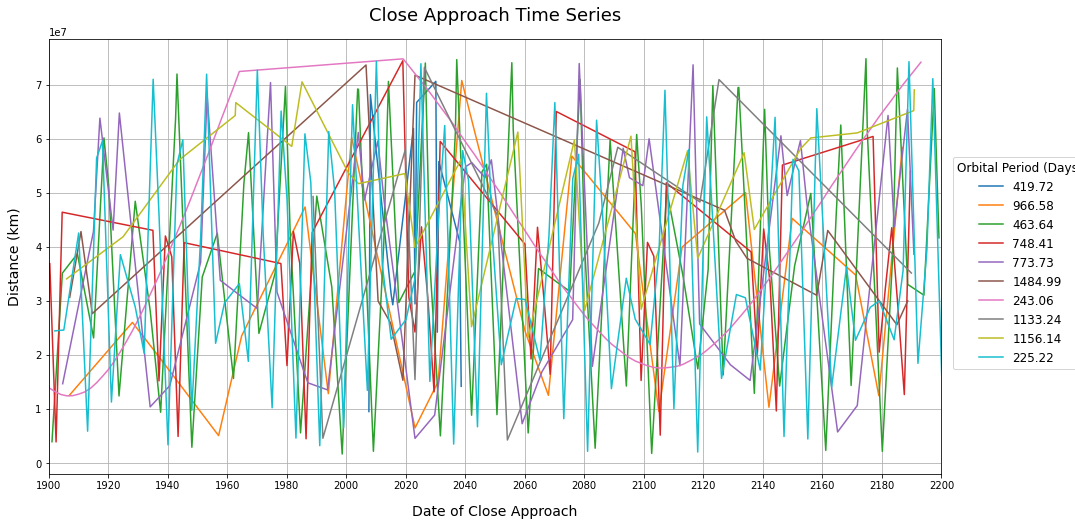

In [207]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title('Close Approach Time Series', fontsize=18, pad=18)

ax.set_xlabel('Date of Close Approach', labelpad=14, fontsize=14)
ax.set_ylabel('Distance (km)', labelpad=14, fontsize=14)

# Borrowed from Matplotlib's guide
locator = mdates.AutoDateLocator(maxticks=25)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_xlim(left=datetime.date(1900, 1, 1), right=datetime.date(2200, 1, 1))

ax.grid(True)

for id in neo_datasets:
    x = neo_datasets[id]['approach_dates']
    y = neo_datasets[id]['miss_distances']
    orbital_period = float(neo_datasets[id]['orbital_period'])
    ax.plot(x, y, label=f'{orbital_period:.2f}')

fig.legend(title='Orbital Period (Days)', loc='right', borderaxespad=-1, title_fontsize=12, fontsize=12)

plt.show()